# CSC 580 Final Project

### Note: 
The data set I am using has about 78,000 data points, training can take about 250 minutes with the entire set. If you want to speed things up, set the value below to the percentage of the data set to use. That percent of the data set will be randomly sampled from the original.

In [56]:
p = 1  # can be (0, 1]

### Imports

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, zero_one_loss

from scipy.optimize import curve_fit

### Load the data and split into train and test sets

In [58]:
df = pd.read_csv('./data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

if p < 1:
    df = resample(df, replace=False, n_samples=int(df.shape[0] * p)) # TODO finish this

X = df.drop('Diabetes_binary', axis=1).to_numpy()
y = df['Diabetes_binary'].to_numpy()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
assert len(Xtrain) == len(ytrain) and len(Xtest) == len(ytest)

len(X)

70692

### Create $m$ datasets using PCA to reduce to $m, m-1, ..., 1$ dimensions

In [59]:
m = np.size(X, axis=1)
dimensions = np.arange(m, 0, -1)

Xtrain_pca =  []
Xtest_pca = []
for n in dimensions:
    if n == m:
        Xtrain_pca.append(Xtrain)
        Xtest_pca.append(Xtest)
    else:
        pca = PCA(n_components=n)
        Xtrain_pca.append(pca.fit(Xtrain).transform(Xtrain))
        Xtest_pca.append(pca.fit(Xtest).transform(Xtest))
#     explained_variance = pd.DataFrame(pca.fit(Xtrain).explained_variance_)
#     ax = explained_variance.plot.bar(legend=False, figsize=(8, 4))
# plt.tight_layout()
# plt.show()

### Interpret each learned principle component

In [60]:
# TODO

### Define a training procedure for each model

In [67]:
kfolds = 5

def train_decision_tree(X, y):
    clfs = []
    # try values of max depth from 1 to the number of features
    for md in range(1, np.size(X, axis=1) + 1):
        clf = DecisionTreeClassifier(max_depth=md)
        scores = cross_val_score(clf, X=X, y=y, cv=kfolds)
        clfs.append((clf, np.mean(scores)))
    clf = max(clfs, key=lambda x: x[1])[0]
    return clf.fit(X, y)

def train_k_nearest_neighbors(X, y):
    clfs = []
    # try values of k from 3 to 10
    for k in range(3, 11):
        clf = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(clf, X=X, y=y, cv=kfolds)
        clfs.append((clf, np.mean(scores)))
    clf = max(clfs, key=lambda x: x[1])[0]
    return clf.fit(X, y)
    
def train_perceptron(X, y):
    clfs = []
    # try values of alpha from 0.0001 to 1
    for alpha in (0.0001, 0.001, 0.01, 0.1, 1):
        clf = Perceptron(penalty='l2', alpha=alpha)
        scores = cross_val_score(clf, X=X, y=y, cv=kfolds)
        clfs.append((clf, np.mean(scores)))
    clf = max(clfs, key=lambda x: x[1])[0]
    return clf.fit(X, y)

def train_logistic_regression(X, y):
    clfs = []
    # try values of C from 0.01 to 100
    for C in (0.01, 0.1, 1, 10, 100):
        clf = LogisticRegression(penalty='l2', C=C, max_iter=1000)
        scores = cross_val_score(clf, X=X, y=y, cv=kfolds)
        clfs.append((clf, np.mean(scores)))
    clf = max(clfs, key=lambda x: x[1])[0]
    return clf.fit(X, y)

def train_support_vector_machine(X, y):
    clfs = []
    # try values of C from 0.01 to 100
    for C in (0.01, 0.1, 1, 10, 100):
        clf = SVC(C=C)
        scores = cross_val_score(clf, X=X, y=y, cv=kfolds)
        clfs.append((clf, np.mean(scores)))
    clf = max(clfs, key=lambda x: x[1])[0]
    return clf.fit(X, y)

training_procedures = {
    'DecisionTree': train_decision_tree,
    'KNearestNeighbors': train_k_nearest_neighbors,
    'Perceptron': train_perceptron,
    'LogisticRegression': train_logistic_regression,
    'SupportVectorMachine': train_support_vector_machine
}

### Define scoring procedures

In [68]:
scoring_procedures = {
    'Zero-One Loss': zero_one_loss,
    'F1 Score': f1_score
}

### Train and score each model on each dataset produced from PCA

In [69]:
model_predictions = {}
for model_name, train in training_procedures.items():
    model_predictions[model_name] = []
    for Xtrain, Xtest in tqdm(zip(Xtrain_pca, Xtest_pca), desc=model_name, total=len(Xtrain_pca)):
        model = train(Xtrain, ytrain)
        yhat =  model.predict(Xtest)
        model_predictions[model_name].append(yhat)

all_model_scores = {}
for scoring_name, score in scoring_procedures.items():
    all_model_scores[scoring_name] = {}
    for model_name, predictions in model_predictions.items():
        all_model_scores[scoring_name][model_name] = [score(ytest, yhat) for yhat in predictions]

DecisionTree:   0%|          | 0/21 [00:00<?, ?it/s]

KNearestNeighbors:   0%|          | 0/21 [00:00<?, ?it/s]

Perceptron:   0%|          | 0/21 [00:00<?, ?it/s]

LogisticRegression:   0%|          | 0/21 [00:00<?, ?it/s]

SupportVectorMachine:   0%|          | 0/21 [00:00<?, ?it/s]

### Visualize the results

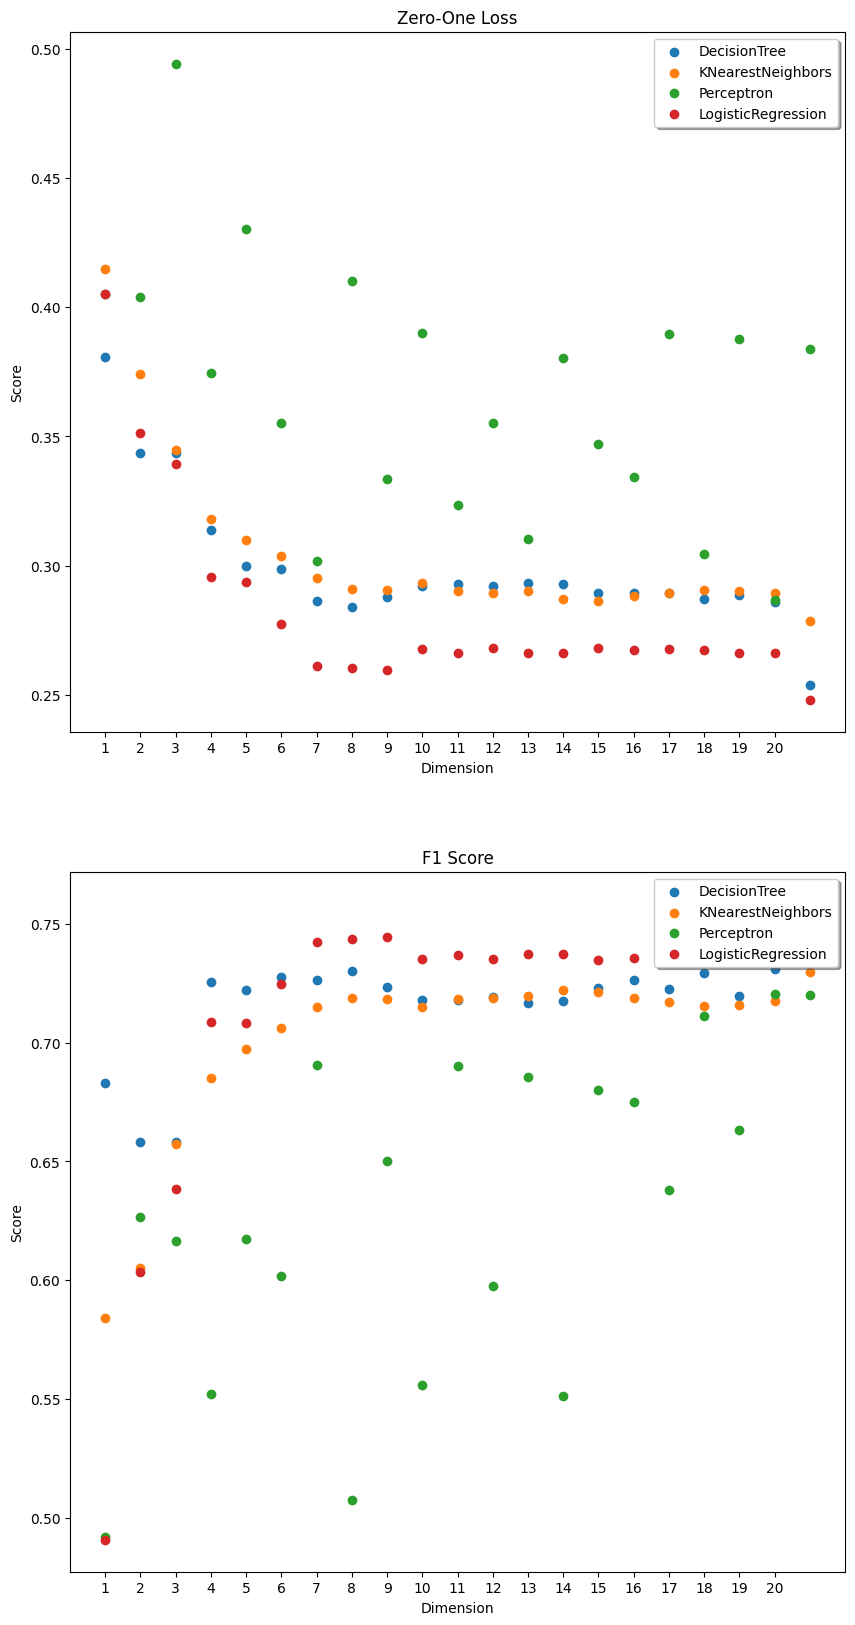

In [ ]:
fig, axs = plt.subplots(len(all_model_scores), figsize=(10, 20))
axs = axs.flatten()
for i, (scoring_name, model_scores) in enumerate(all_model_scores.items()):
    ax = axs[i]

    plots = []
    model_names = []
    for model_name, scores in model_scores.items():
        plot = ax.scatter(dimensions, scores)

        # fit a quadratic curve to the scatter plot
        # def quadratic(x, a, b, c, d):
        #     return a * x**3 + b * x**2 + c * x + d

        # popt, _ = curve_fit(quadratic, dimensions, scores)
        # ax.plot(dimensions, quadratic(dimensions, *popt))
        plots.append(plot)
        model_names.append(model_name)
        
    ax.legend(plots, model_names, loc='upper right', shadow=True)
    ax.set_xticks(range(np.min(dimensions), np.max(dimensions))) 
    ax.set_title(scoring_name)
    ax.set_xlabel('Dimension')
    ax.set_ylabel('Score')
plt.show()